## PyTorch

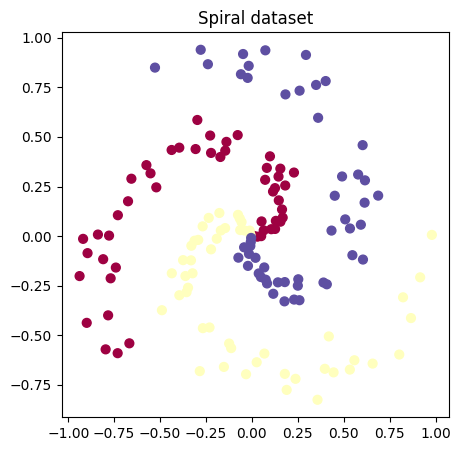

Epoch 0: loss=1.1140, acc=0.333
Epoch 200: loss=0.1422, acc=0.950
Epoch 400: loss=0.0271, acc=0.992
Epoch 600: loss=0.0108, acc=1.000
Epoch 800: loss=0.0056, acc=1.000
Epoch 1000: loss=0.0031, acc=1.000
Epoch 1200: loss=0.0015, acc=1.000
Epoch 1400: loss=0.0009, acc=1.000
Epoch 1600: loss=0.0006, acc=1.000
Epoch 1800: loss=0.0004, acc=1.000
Test accuracy: 0.967


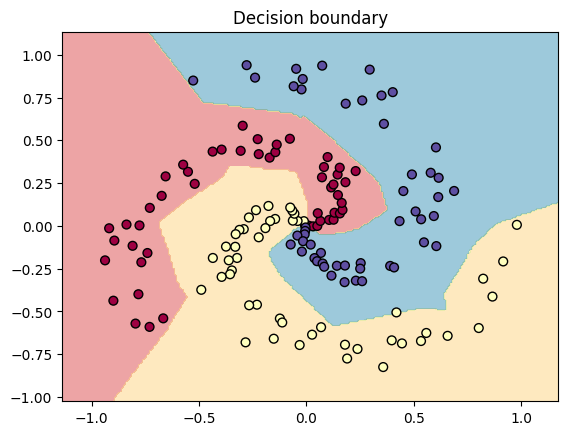

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# 1. Generate spiral dataset
def make_spiral(N=100, K=3, noise=0.3, dTheta=4):
    X = np.zeros((N*K, 2))
    y = np.zeros(N*K, dtype=np.int64)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        r = np.linspace(0.01, 1, N)
        t = np.linspace(j*(2*np.pi)/K, j*(2*np.pi)/K + dTheta, N) + np.random.randn(N)*noise
        X[ix] = np.c_[r*np.cos(t), r*np.sin(t)]
        y[ix] = j
    return X, y

N, K = 50, 3
X, y = make_spiral(N, K)
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap='Spectral', s=40)
plt.title("Spiral dataset")
plt.show()

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Prepare PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 4. Define model
class SpiralNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=16, output_dim=K):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

model = SpiralNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 5. Training
epochs = 2000
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(X_train_tensor)
    loss = criterion(out, y_train_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 200 == 0:
        pred = out.argmax(dim=1)
        acc = (pred == y_train_tensor).float().mean().item()
        print(f"Epoch {epoch}: loss={loss.item():.4f}, acc={acc:.3f}")

# 6. Test accuracy
with torch.no_grad():
    test_pred = model(X_test_tensor).argmax(dim=1)
    test_acc = (test_pred == y_test_tensor).float().mean().item()
print(f"Test accuracy: {test_acc:.3f}")

# 7. Visualize decision boundary
def plot_decision_boundary(model, X, y, K):
    h = 0.01
    x_min, x_max = X[:,0].min()-0.2, X[:,0].max()+0.2
    y_min, y_max = X[:,1].min()-0.2, X[:,1].max()+0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    with torch.no_grad():
        Z = model(torch.tensor(grid, dtype=torch.float32)).argmax(dim=1).numpy()
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.5, cmap='Spectral', levels=K)
    plt.scatter(X[:,0], X[:,1], c=y, cmap='Spectral', s=40, edgecolor='k')
    plt.title("Decision boundary")
    plt.show()

plot_decision_boundary(model, X, y, K)

## JAX 

Epoch 0: train acc=0.375
Epoch 200: train acc=1.000
Epoch 400: train acc=1.000
Epoch 600: train acc=1.000
Epoch 800: train acc=1.000
Epoch 1000: train acc=1.000
Epoch 1200: train acc=1.000
Epoch 1400: train acc=1.000
Epoch 1600: train acc=1.000
Epoch 1800: train acc=1.000
Test accuracy: 0.933


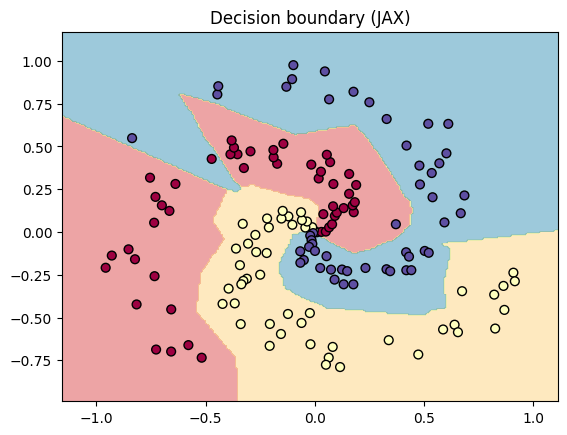

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import optax
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1. Generate spiral dataset
def make_spiral(N=100, K=3, noise=0.3, dTheta=4):
    X = np.zeros((N*K, 2))
    y = np.zeros(N*K, dtype=np.int32)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        r = np.linspace(0.01, 1, N)
        t = np.linspace(j*(2*np.pi)/K, j*(2*np.pi)/K + dTheta, N) + np.random.randn(N)*noise
        X[ix] = np.c_[r*np.cos(t), r*np.sin(t)]
        y[ix] = j
    return X, y

N, K = 50, 3
X, y = make_spiral(N, K)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Initialize parameters
key = jax.random.PRNGKey(0)
def init_layer(key, in_dim, out_dim):
    k1, k2 = jax.random.split(key)
    W = jax.random.normal(k1, (in_dim, out_dim)) * jnp.sqrt(2/in_dim)
    b = jnp.zeros((out_dim,))
    return W, b

def init_network(key, sizes):
    keys = jax.random.split(key, len(sizes))
    params = []
    for k, (in_dim, out_dim) in zip(keys, zip(sizes[:-1], sizes[1:])):
        params.append(init_layer(k, in_dim, out_dim))
    return params

layer_sizes = [2, 16, 16, K]
params = init_network(key, layer_sizes)

# 3. Define forward pass
def relu(x):
    return jnp.maximum(0, x)

def forward(params, x):
    for W, b in params[:-1]:
        x = relu(jnp.dot(x, W) + b)
    W, b = params[-1]
    return jnp.dot(x, W) + b

def predict(params, x):
    logits = forward(params, x)
    return jnp.argmax(logits, axis=-1)

# 4. Define loss and accuracy
def loss_fn(params, x, y):
    logits = forward(params, x)
    labels = jax.nn.one_hot(y, K)
    loss = optax.softmax_cross_entropy(logits, labels).mean()
    return loss

@jit
def accuracy(params, x, y):
    preds = predict(params, x)
    return jnp.mean(preds == y)

# 5. Training
optimizer = optax.adam(1e-2)
opt_state = optimizer.init(params)

@jit
def update(params, opt_state, x, y):
    grads = jax.grad(loss_fn)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

X_train_jax = jnp.array(X_train)
y_train_jax = jnp.array(y_train)
X_test_jax = jnp.array(X_test)
y_test_jax = jnp.array(y_test)

for epoch in range(2000):
    params, opt_state = update(params, opt_state, X_train_jax, y_train_jax)
    if epoch % 200 == 0:
        train_acc = accuracy(params, X_train_jax, y_train_jax)
        print(f"Epoch {epoch}: train acc={train_acc:.3f}")

test_acc = accuracy(params, X_test_jax, y_test_jax)
print(f"Test accuracy: {test_acc:.3f}")

# 6. Visualize decision boundary
def plot_decision_boundary(params, X, y, K):
    h = 0.01
    x_min, x_max = X[:,0].min()-0.2, X[:,0].max()+0.2
    y_min, y_max = X[:,1].min()-0.2, X[:,1].max()+0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.array([predict(params, xi) for xi in grid])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.5, cmap='Spectral', levels=K)
    plt.scatter(X[:,0], X[:,1], c=y, cmap='Spectral', s=40, edgecolor='k')
    plt.title("Decision boundary (JAX)")
    plt.show()

plot_decision_boundary(params, X, y, K)

Comparison: Strengths of JAX vs PyTorch

**JAX Strengths:**

- Syntax is close to NumPy, making it easy for scientific computing and prototyping
- Supports automatic differentiation (`grad`), automatic vectorization (`vmap`), and JIT compilation (`jit`), which can greatly improve performance
- Well-suited for research, physics simulations, differential equations, and machine learning theory
- Easy to run on GPU/TPU, integrates well with the Google ecosystem (Flax, Haiku, Optax)

**PyTorch Strengths:**

- Complete ecosystem, supports a wide range of deep learning applications (CV, NLP, RL, etc.)
- Dynamic computation graph, easy to debug and develop complex models
- Large community, rich resources, and integrates well with mainstream ML toolchains (e.g., HuggingFace, PyTorch Lightning)
- Suitable for industrial applications and large-scale deployment

**Summary:**

- JAX is suitable for high-performance numerical computing, scientific computing, differential equations, and research-oriented prototyping
- PyTorch is suitable for mainstream deep learning applications, industrial deployment, and complex neural network development

## PennyLane: Full Example and Explanation of Quantum Circuit Classification for Spiral Data, Compared with Classical Neural Networks.

1. Quantum Data Embedding (Feature Map)
Embed 2D spiral data points (x, y) into quantum states. A common approach is to use parameterized rotation gates (such as RX, RY, RZ).